### GMSH+FEM

In [1]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
from zeroheliumkit import Structure, Rectangle, Square, Ring, Circle
from zeroheliumkit.src.settings import GRAY, BLUE, YELLOW2
from zeroheliumkit.src.plotting import ColorHandler

In [3]:
save_dir = "dump/"

### Creating geometry

<Axes: >

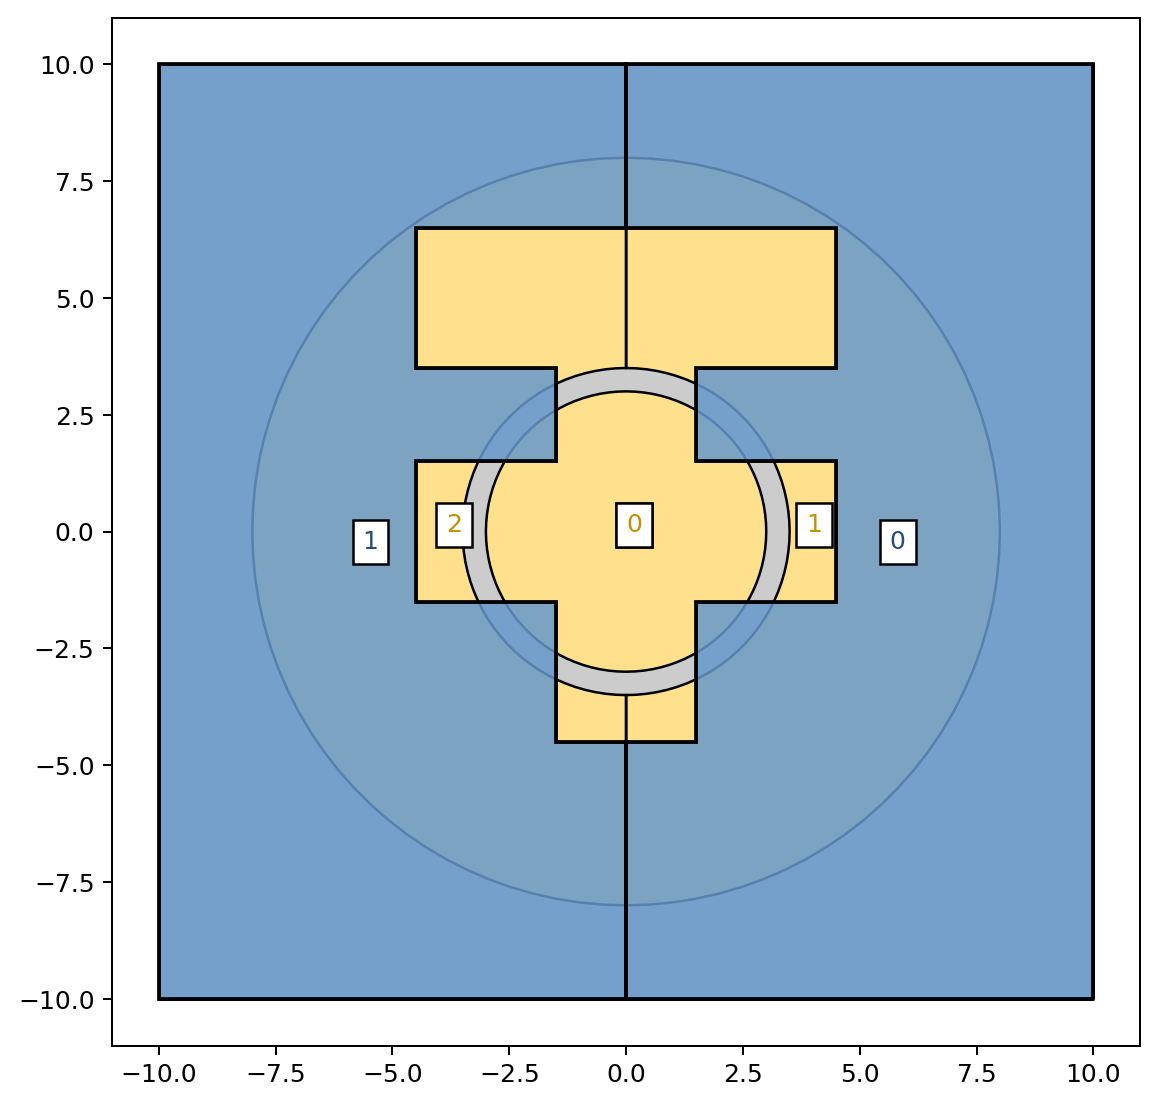

In [4]:
device = Structure()
device.add_layer("wafer", Square(20))
device.add_layer("gnd", Square(20))
device.cut_polygon("gnd", Rectangle(3, 9))
device.cut_polygon("gnd", Rectangle(9, 3))
device.cut_polygon("gnd", Rectangle(9, 3, (0,5)))
device.add_layer("bottom", Circle(3))
device.add_polygon("bottom", Ring(3.5, 8))
device.add_layer("etch", Square(20))
device.cut_polygon("etch", device.gnd)

device.remove_holes_from_polygons("bottom")
device.remove_holes_from_polygons("gnd")

device.colors = ColorHandler({
    "wafer": GRAY,
    "bottom": YELLOW2,
    "gnd": (BLUE, 0.85)
})
device.quickplot(show_idx=True)

### **Creating Mesh**

In [ ]:
from zeroheliumkit.fem import GMSHmaker, ExtrudeSettings, MeshSettings, PECSettings, BoxFieldMeshSettings

In [8]:
# extrude parameters
d_wafer     = 10
d_metal1    = 0.2
d_metal2    = 0.1
d_diel      = 1.5
d_vac       = 20
d_He        = d_diel + d_metal2

In [9]:
Volumes = {
    'wafer':        ExtrudeSettings(device.wafer, -d_wafer, d_wafer, 'DIELECTRIC'),
    'trap':         ExtrudeSettings(device.bottom, 0, d_metal1, 'METAL'),
    'dielectric':   ExtrudeSettings(device.gnd, 0, d_diel, 'DIELECTRIC', ('trap',)),
    'top':          ExtrudeSettings(device.gnd, d_diel, d_metal2, 'METAL'),
    'helium':       ExtrudeSettings(device.wafer, 0, d_He, 'HELIUM', ('trap', 'dielectric','top')),
    'vacuum':       ExtrudeSettings(device.wafer, d_He, d_vac, 'VACUUM', ('dielectric', 'top'))
}

PECs = {
    'mid':   PECSettings(device.bottom, [0], volume=Volumes['trap']),
    'out':   PECSettings(device.bottom, [1,2], volume=Volumes['trap']),
    'top':   PECSettings(device.gnd, [0,1], volume=Volumes['top']),
}

scale = 4 # scaling factor for meshing. default 1.8

mesh = MeshSettings(
    dim = 3,
    fields = {
        "Box": [BoxFieldMeshSettings(Thickness=4, VIn=scale * 0.2, VOut=scale * 2, box=[-10, 10, 10, 10, -5, 5]),
                BoxFieldMeshSettings(Thickness=2, VIn=scale * 0.1, VOut=scale * 2, box=[-8, 8, -8, 8, -2, 2])]
    }
)

In [10]:
meshMKR = GMSHmaker(
    extrude = Volumes,
    surfaces = None,
    pecs = PECs,
    mesh = mesh,
    save = {"dir": save_dir, "filename": "dot"},
    open_gmsh = True,
    debug_mode = False
)

on 0: mesh is constructed                                                       
on 0: mesh saved                                                                
Gmsh generation  |███| 1/1 [100%] in 3.0s (0.33/s)                              


Below is an example of created geometry and a mesh using GMSH.

<img src="../_static/fig1.png" width="800"/>

In [11]:
meshMKR.print_physical()

Volume        ID
----------  ----
VACUUM         1
DIELECTRIC     2
HELIUM         3
METAL          4

 #-----------------------------------

Surface      ID
---------  ----
mid           5
out           6
top           7


### **Helium Surface Displacement calculations**

<Axes: >

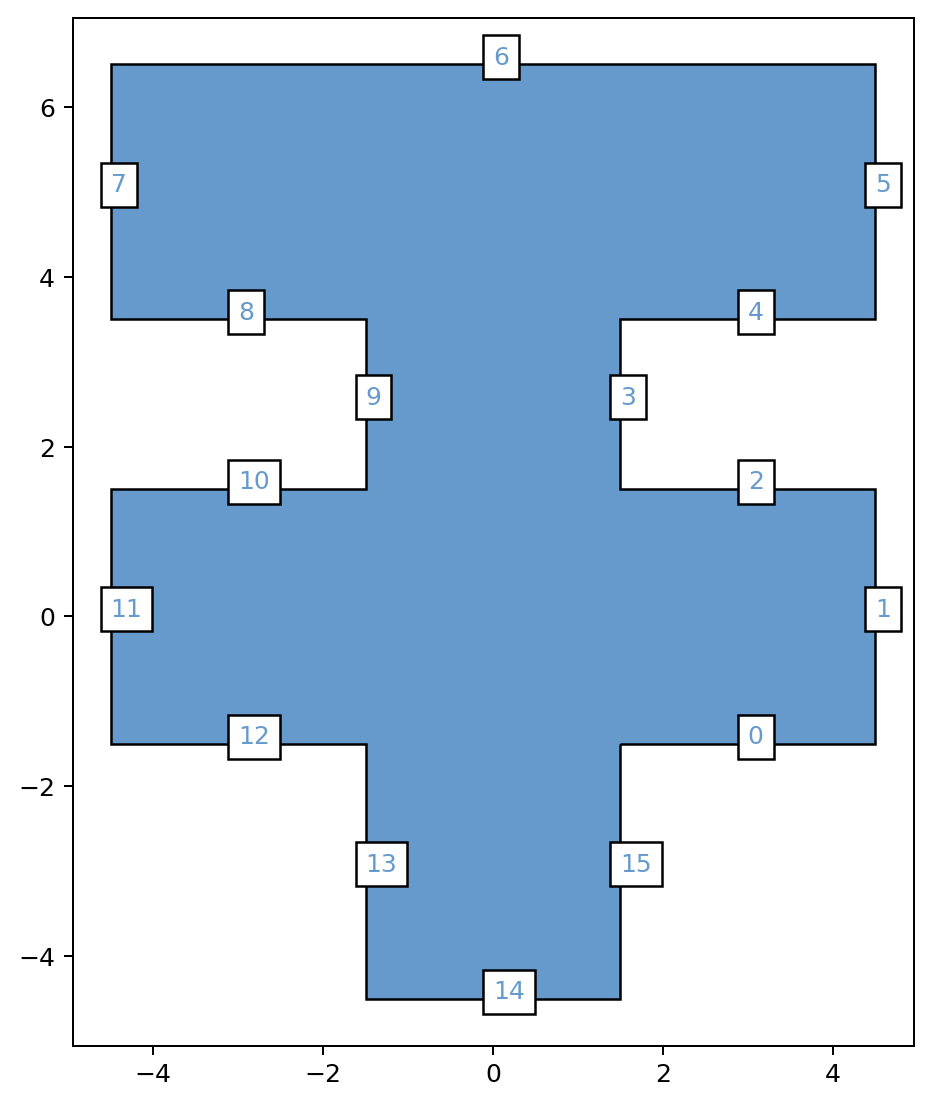

In [12]:
s = Structure()
s.add_layer('etch', device.etch)
s.quickplot(show_line_idx=True)

# We want to make boundary with line id 1 and 11 to be open boundary (Neumann boundary),
# at all other boundaries displacement is set to 0 (Dirichlet boundary)

In [13]:
from zeroheliumkit.fem.heliumsurface import GMSHmaker2D, HeliumSurfaceFreeFEM

In [14]:
gmshmkr = GMSHmaker2D(layout = s,
                      electode_config = {"type": "polygon",
                                         "bound": {"layer": ("etch", (0,)), "exclude": [1,11], "value": 0}},
                      mesh_config = [{"Thickness": 5, "VIn": 0.9, "VOut": 0.9, "box": [-20, -10, 20, 10]}],
                      filename = "heliumsurface",
                      savedir = save_dir)
gmshmkr.disable_consoleOutput()
gmshmkr.create_mesh()
#gmshmkr.open_gmsh()
gmshmkr.finalize()

Gmsh generation  |███| 1/1 [100%] in 0.1s (9.41/s)                              


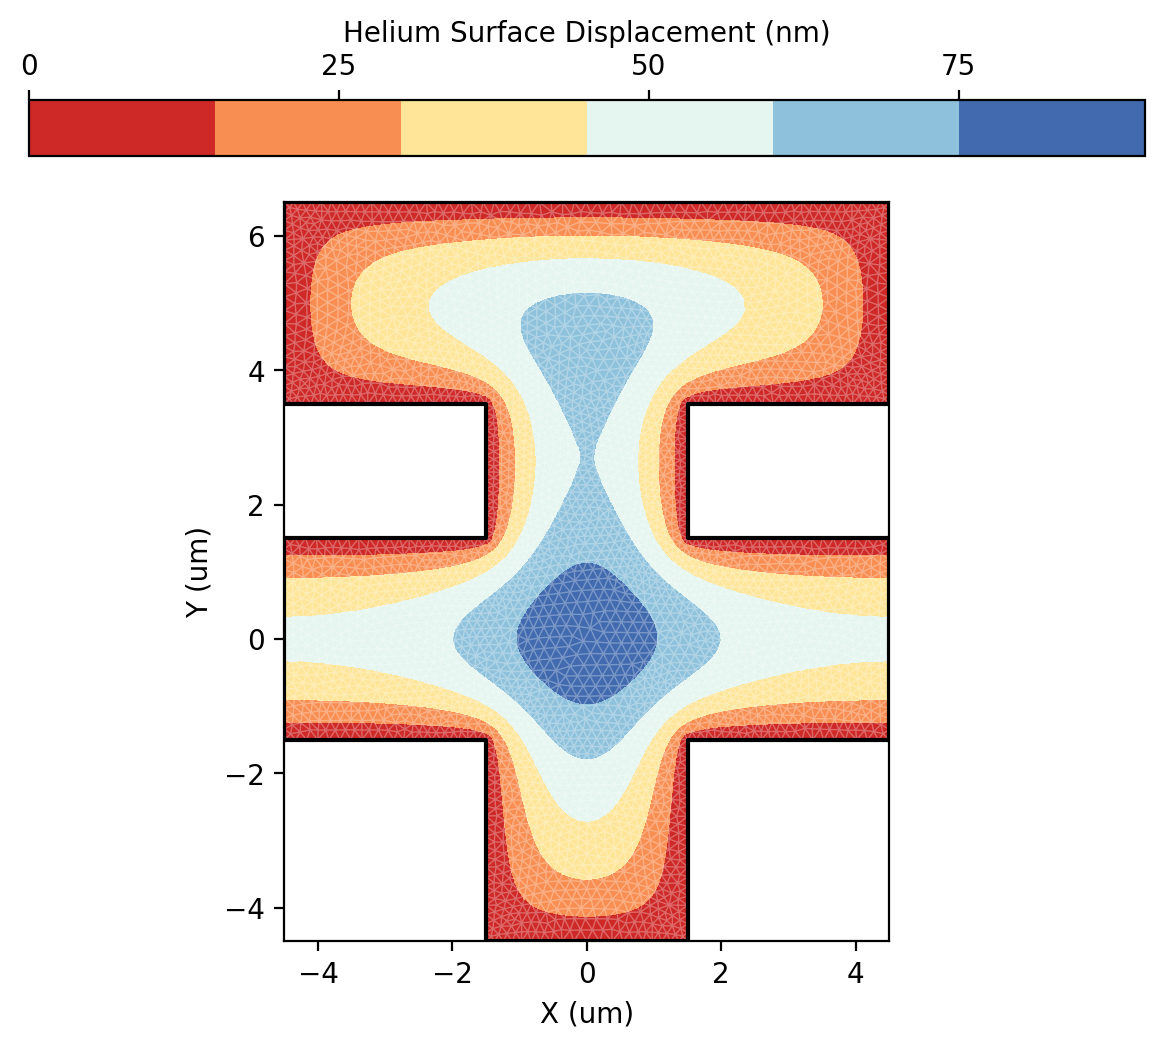

In [15]:
hsfreefem = HeliumSurfaceFreeFEM(fem_config=gmshmkr.export_physical())
res = hsfreefem.run_pyfreefem()

# plotting results of helium surface displacement for a bulk helium distance of 10 cm from the gnd surface
# note: the geometry units are in micrometers, so the bulk helium distance is set to 0.01 (10 cm)
hsfreefem.plot_results(res, bulk_helium_distance=0.01)

In [16]:
curvature_config = hsfreefem.get_code_config(bulk_helium_distances=[0, 0.001, 0.01, 0.02], surface_helium_level=d_He)
# curvature_config

### **Creating FreeFem configuration**

In [17]:
from zeroheliumkit.fem.freefemer import FFconfigurator, ExtractConfig, FreeFEM

In [20]:
He_level = d_He

var_eps = {
        'DIELECTRIC': 11.0,
        'METAL': 1.0,
        'HELIUM': 1.057,
        'VACUUM': 1.0,
}

ffc = FFconfigurator(config_file="dump/dot.yaml",
                     dielectric_constants=var_eps,
                     ff_polynomial=2,
                     extract_opt=[ExtractConfig("result1", 'phi', 'xy', (-10,10,201), (-10,10,201), d_He),
                                  ExtractConfig("result2", 'phi', 'xy', (-10,10,201), (-10,10,201), curvature_config),
                                  ExtractConfig("result3", 'Ez', 'yz', (-10,10,101), (-2,2,101), 0.0)
                                  ],
                     msh_refinements=None
                     )

In [21]:
pyff = FreeFEM(config_file="dump/dot.yaml")

In [22]:
await pyff.run(cores=4, print_log=False, freefem_path=":/Applications/FreeFem++.app/Contents/ff-4.15.1/bin", remove_txt_files=True)

Label(value='⏳ Running calculations for electrode_mid.edp')

Label(value='⏳ Running calculations for electrode_out.edp')

Label(value='⏳ Running calculations for electrode_top.edp')

Freefem calculations are complete. Ran in 10.31 seconds.


### **Parsing FEM results**

In [23]:
from zeroheliumkit.fem.fieldreader import FreeFemResultParser, FieldAnalyzer
from zeroheliumkit.src.settings import BLACK, WHITE

In [24]:
ffparser = FreeFemResultParser("dump/metadata.yaml")

                result1        result2                 result3
--------------  -------------  ----------------------  -------------
Quantity        phi            phi                     Ez
Plane           xy             xy                      yz
X Min           -10            -10                     -10
X Max           10             10                      10
X Num           201            201                     101
Y Min           -10            -10                     -2
Y Max           10             10                      2
Y Num           201            201                     101
Slices          1              4                       1
Slice Values    [1.6]          [0, 0.001, 0.01, 0.02]  [0.0]
Curved Surface  False          True                    False
Schema          (1, 201, 201)  (4, 201, 201)           (1, 101, 101)
Control Electrodes: ['mid', 'out', 'top']


In [25]:
ffparser.get_capacitance_matrix()

[[-321.433, 266.481, 67.7825],
 [258.134, -1859.7, 1725.85],
 [63.2999, 1593.21, -1793.63]]

In [26]:
fa = FieldAnalyzer(("dot", ffparser.load_data(save_dir, "result1")),
                   ("curved", ffparser.load_data(save_dir, "result2")))

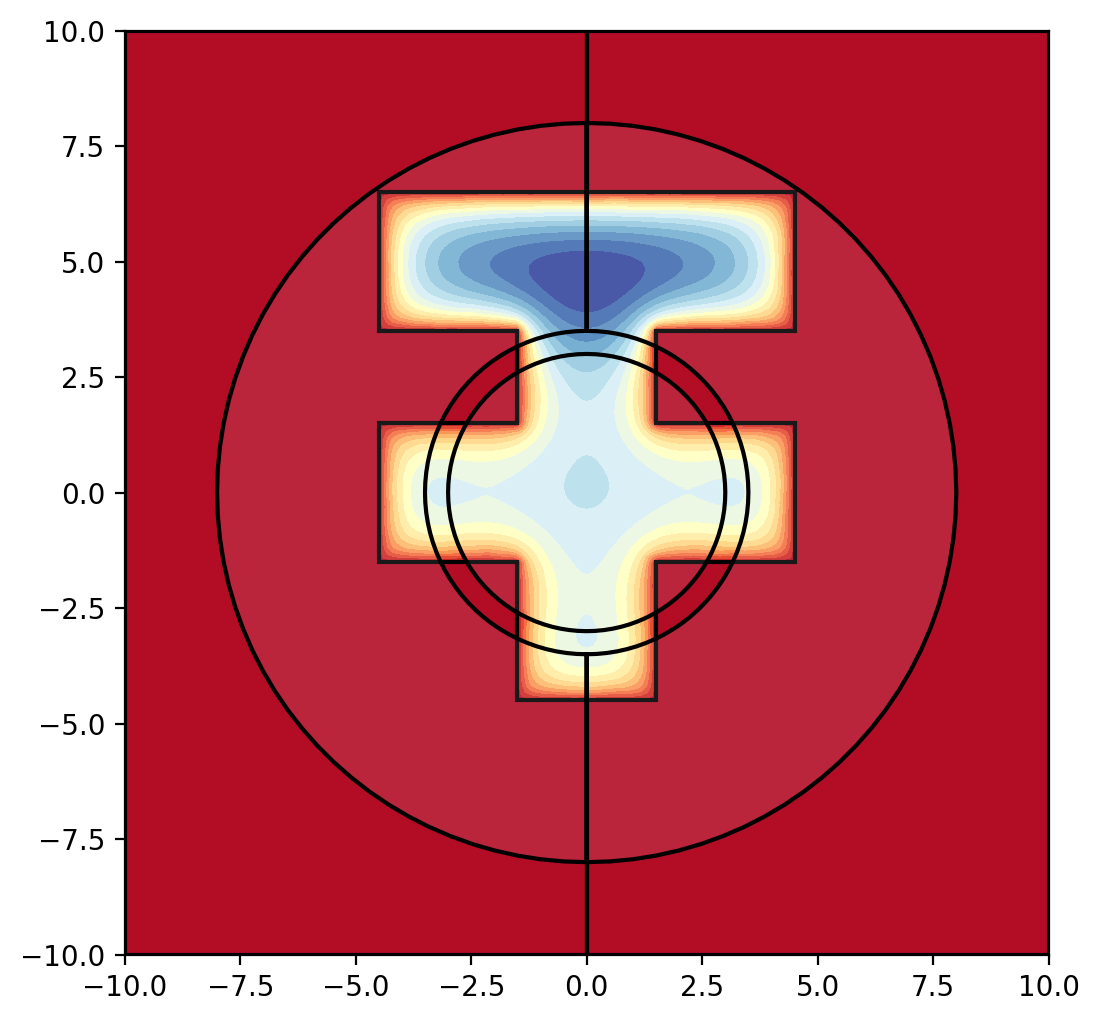

In [27]:
voltages = {
    "mid": 1,
    "out": 2,
    "top": -0.1
}

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

fa.plot_potential_2D(fa.dot, voltages, zlevel_key=1.6, ax=ax, zero_line=False, cmap='RdYlBu')
device.plot(ax=ax, layer=["gnd"], color=[BLACK], alpha=0)
device.plot(ax=ax, layer=["bottom"], color=[WHITE], alpha=0.1)

ax.set_aspect("equal")

plt.show()

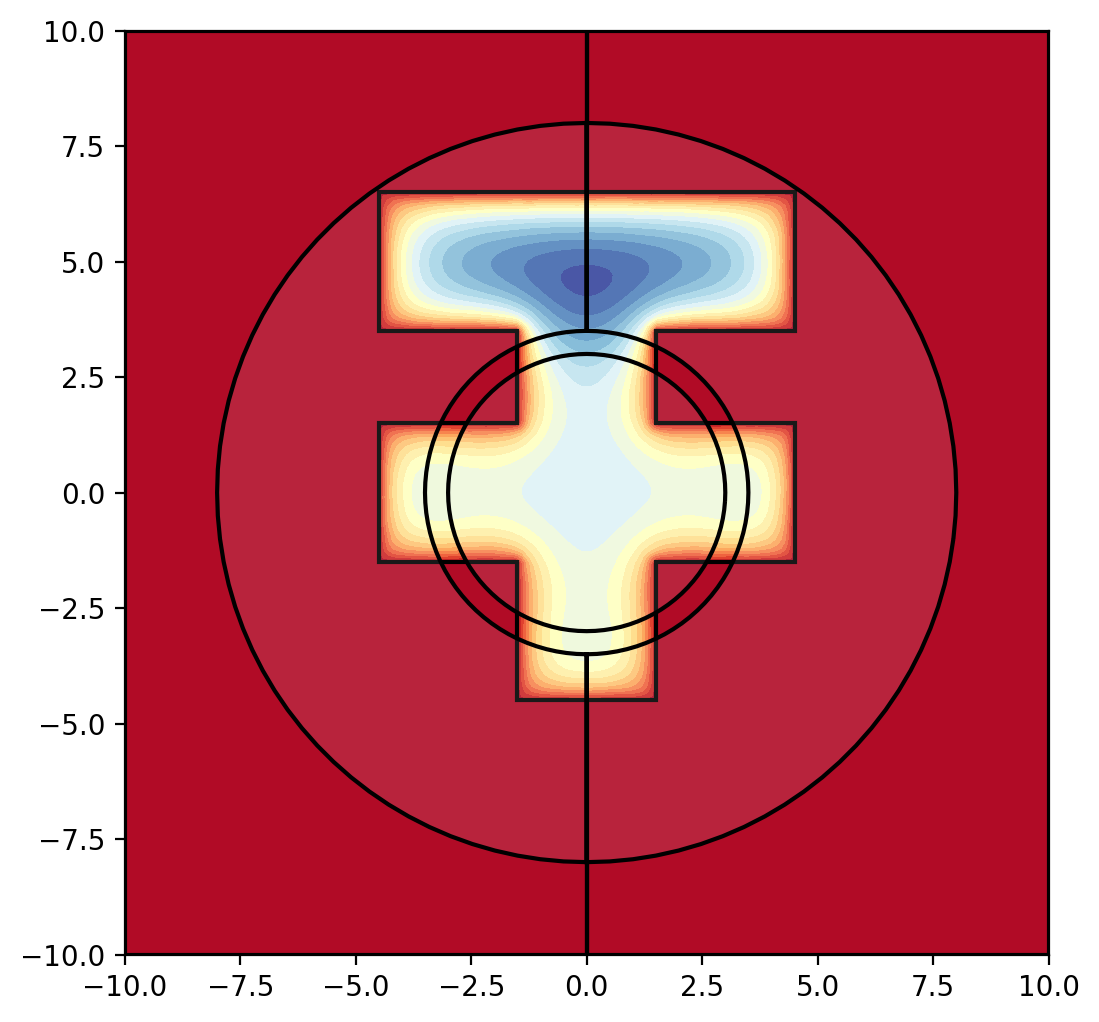

In [28]:
voltages = {
    "mid": 1,
    "out": 2,
    "top": -0.1
}

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

fa.plot_potential_2D(fa.curved, voltages, zlevel_key=0.02, ax=ax, zero_line=False, cmap='RdYlBu')
device.plot(ax=ax, layer=["gnd"], color=[BLACK], alpha=0)
device.plot(ax=ax, layer=["bottom"], color=[WHITE], alpha=0.1)

ax.set_aspect("equal")

plt.show()